In [1]:
import sys, numpy as np
from keras.datasets import mnist
from matplotlib import pyplot as plt

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Load data

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 10s 1us/step


## Prepare training and test data

In [3]:
x_train, y_train = (x_train[0:1000].reshape(1000, 28 * 28) / 255.0, y_train[0:1000])

def convert_to_one_hot(arr, c):
    one_hot_labels = np.zeros((len(arr), c))
    
    for i, l in enumerate(arr):
        one_hot_labels[i][l] = 1.0
        
    return one_hot_labels

y_train = convert_to_one_hot(y_train, 10)

x_test = x_test.reshape(len(x_test), 28 * 28) / 255.0
y_test = convert_to_one_hot(y_test, 10)

In [4]:
def show_image(data, id):
    image = (data[id].reshape((28, 28)) * 255.0).astype(np.uint8)
    plt.imshow(image, interpolation='nearest')

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


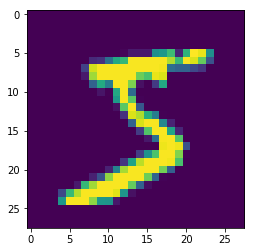

In [5]:
show_image(x_train, 0)
print(y_train[0])

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


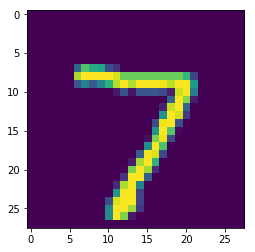

In [6]:
show_image(x_test, 0)
print(y_test[0])

## Training

In [17]:
np.random.seed(1)

relu = lambda x: (x >= 0.0) * x
relu_backwards = lambda x: x >= 0.0

lr = 0.005
epochs = 350
hidden_size = 40
pixels_per_image = 784
num_labels = 10

weights_0_1 = 0.2 * np.random.random((pixels_per_image, hidden_size)) - 0.1
weights_1_2 = 0.2 * np.random.random((hidden_size, num_labels)) - 0.1

def forward(x):
    layer_0 = x
    layer_1 = relu(np.dot(layer_0, weights_0_1))
    layer_2 = np.dot(layer_1, weights_1_2)
    return layer_2

for j in range(epochs):
    
    error, correct_cnt = (0.0, 0)
    
    for i in range(len(x_train)):
        # Forward pass
        layer_2 = forward(x_train[i:i+1])
        
        # Calculate loss
        error += np.sum((y_train[i:i+1] - layer_2) ** 2.0)
        correct_cnt += int(np.argmax(layer_2) == np.argmax(y_train[i:i+1]))
        
        # Backward pass
        layer_2_delta = (y_train[i:i+1] - layer_2)
        layer_1_delta = layer_2_delta.dot(weights_1_2.T) * relu_backwards(layer_1)
        
        # Parameter update
        weights_1_2 += lr * layer_1.T.dot(layer_2_delta)
        weights_0_1 += lr * layer_0.T.dot(layer_1_delta)
    
    # Test accuracy
    if(j % 10 == 0 or j == epochs - 1):

        error, correct_cnt = (0.0, 0)

        for i in range(len(x_test)):
            layer_2 = forward(x_test[i:i+1])

            error += np.sum((y_test[i:i+1] - layer_2) ** 2.0)
            correct_cnt += int(np.argmax(layer_2) == np.argmax(y_test[i:i+1]))

        sys.stdout.write(" test error: " + str(error / float(len(x_test)))[0:5] + \
                         " test accuracy: " + str(correct_cnt / float(len(x_test))))
        print()
    
    sys.stdout.write("\r" + \
        " epoch: " + str(j) + \
        " error: " + str(error / float(len(x_train)))[0:5] + \
        " percent correct: " + str(correct_cnt / float(len(x_train))))

 test error: 1.042 test accuracy: 0.0571
 epoch: 5 error: 1.016 percent correct: 0.053

KeyboardInterrupt: 

## Dropout

In [22]:
np.random.seed(1)

relu = lambda x: (x >= 0.0) * x
relu_backwards = lambda x: x >= 0.0

lr = 0.005
epochs = 300
hidden_size = 100
pixels_per_image = 784
num_labels = 10

weights_0_1 = 0.2 * np.random.random((pixels_per_image, hidden_size)) - 0.1
weights_1_2 = 0.2 * np.random.random((hidden_size, num_labels)) - 0.1

training_errors = []
test_errors = []

for j in range(epochs):
    
    error, correct_cnt = (0.0, 0)
    
    for i in range(len(x_train)):
        # Forward pass
        layer_0 = x_train[i:i+1]
        layer_1 = relu(np.dot(layer_0, weights_0_1))
        dropout_mask = np.random.randint(2, size=layer_1.shape)
        layer_1 *= dropout_mask
        layer_1 *= 2.0
        layer_2 = np.dot(layer_1, weights_1_2)
        
        # Calculate loss
        error += np.sum((y_train[i:i+1] - layer_2) ** 2.0)
        correct_cnt += int(np.argmax(layer_2) == np.argmax(y_train[i:i+1]))
        
        # Backward pass
        layer_2_delta = (y_train[i:i+1] - layer_2)
        layer_1_delta = layer_2_delta.dot(weights_1_2.T) * relu_backwards(layer_1)
        layer_1_delta *= dropout_mask
        
        # Parameter update
        weights_1_2 += lr * layer_1.T.dot(layer_2_delta)
        weights_0_1 += lr * layer_0.T.dot(layer_1_delta)
    
    if(j % 10 == 0):
        
        test_error = 0.0
        test_correct_cnt = 0

        for i in range(len(x_test)):
            # No dropout at test time
            layer_0 = x_test[i:i+1]
            layer_1 = relu(np.dot(layer_0, weights_0_1))
            layer_2 = np.dot(layer_1, weights_1_2)
            
            test_error += np.sum((y_test[i:i+1] - layer_2) ** 2)
            test_correct_cnt += int(np.argmax(layer_2) == np.argmax(y_test[i:i+1]))
        
        sys.stdout.write("\n" + \
            "epoch: " + str(j) + \
            " test error: " + str(test_error / float(len(x_test)))[0:5] +\
            " test accuracy: " + str(test_correct_cnt / float(len(x_test)))+\
            " training error: " + str(error / float(len(x_train)))[0:5] +\
            " training accuracy: " + str(correct_cnt / float(len(x_train))))
        
        training_errors.append(error / float(len(x_train)))
        test_errors.append(test_error / float(len(x_test)))


epoch: 0 test error: 0.641 test accuracy: 0.6333 training error: 0.891 training accuracy: 0.413
epoch: 10 test error: 0.458 test accuracy: 0.787 training error: 0.472 training accuracy: 0.764
epoch: 20 test error: 0.415 test accuracy: 0.8133 training error: 0.430 training accuracy: 0.809
epoch: 30 test error: 0.421 test accuracy: 0.8114 training error: 0.415 training accuracy: 0.811
epoch: 40 test error: 0.419 test accuracy: 0.8112 training error: 0.413 training accuracy: 0.827
epoch: 50 test error: 0.409 test accuracy: 0.8133 training error: 0.392 training accuracy: 0.836
epoch: 60 test error: 0.412 test accuracy: 0.8236 training error: 0.402 training accuracy: 0.836
epoch: 70 test error: 0.412 test accuracy: 0.8033 training error: 0.383 training accuracy: 0.857
epoch: 80 test error: 0.410 test accuracy: 0.8054 training error: 0.386 training accuracy: 0.854
epoch: 90 test error: 0.411 test accuracy: 0.8144 training error: 0.376 training accuracy: 0.868
epoch: 100 test error: 0.411 te

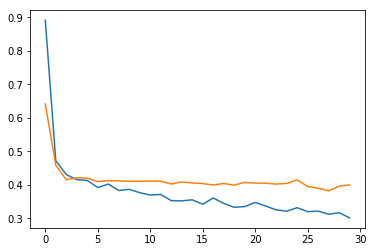

In [30]:
%matplotlib inline
plt.plot(np.arange(len(training_errors)), training_errors, np.arange(len(test_errors)), test_errors)

## Mini-Batch Gradient Descent

In [34]:
np.random.seed(1)

relu = lambda x: (x >= 0.0) * x
relu_backwards = lambda x: x >= 0.0

lr = 0.001
epochs = 300
batch_size = 100
hidden_size = 100
pixels_per_image = 784
num_labels = 10

weights_0_1 = 0.2 * np.random.random((pixels_per_image, hidden_size)) - 0.1
weights_1_2 = 0.2 * np.random.random((hidden_size, num_labels)) - 0.1

training_errors = []
test_errors = []

for j in range(epochs):
    
    error, correct_cnt = (0.0, 0)
    
    for i in range(int(len(x_train) / batch_size)):
        batch_start, batch_end = ((i * batch_size),((i + 1) * batch_size))
        
        # Forward pass
        layer_0 = x_train[batch_start:batch_end]
        layer_1 = relu(np.dot(layer_0, weights_0_1))
        dropout_mask = np.random.randint(2, size=layer_1.shape)
        layer_1 *= dropout_mask
        layer_1 *= 2.0
        layer_2 = np.dot(layer_1, weights_1_2)
        
        error += np.sum((y_train[batch_start:batch_end] - layer_2) ** 2.0)
        
        for k in range(batch_size):
            # Calculate loss
            correct_cnt += int(np.argmax(layer_2[k:k+1]) == np.argmax(y_train[batch_start + k:batch_start + k + 1]))
            
            # Backward pass
            layer_2_delta = (y_train[batch_start:batch_end]-layer_2) / batch_size
            layer_1_delta = layer_2_delta.dot(weights_1_2.T)* relu_backwards(layer_1)
            layer_1_delta *= dropout_mask
            
            # Parameter update
            weights_1_2 += lr * layer_1.T.dot(layer_2_delta)
            weights_0_1 += lr * layer_0.T.dot(layer_1_delta)
    
    if(j % 10 == 0):
        
        test_error = 0.0
        test_correct_cnt = 0

        for i in range(len(x_test)):
            # No dropout at test time
            layer_0 = x_test[i:i+1]
            layer_1 = relu(np.dot(layer_0, weights_0_1))
            layer_2 = np.dot(layer_1, weights_1_2)
            
            test_error += np.sum((y_test[i:i+1] - layer_2) ** 2)
            test_correct_cnt += int(np.argmax(layer_2) == np.argmax(y_test[i:i+1]))
        
        sys.stdout.write("\n" + \
            "epoch: " + str(j) + \
            " test error: " + str(test_error / float(len(x_test)))[0:5] +\
            " test accuracy: " + str(test_correct_cnt / float(len(x_test)))+\
            " training error: " + str(error / float(len(x_train)))[0:5] +\
            " training accuracy: " + str(correct_cnt / float(len(x_train))))
        
        training_errors.append(error / float(len(x_train)))
        test_errors.append(test_error / float(len(x_test)))


epoch: 0 test error: 0.815 test accuracy: 0.3832 training error: 1.284 training accuracy: 0.165
epoch: 10 test error: 0.568 test accuracy: 0.7173 training error: 0.591 training accuracy: 0.672
epoch: 20 test error: 0.510 test accuracy: 0.7571 training error: 0.532 training accuracy: 0.729
epoch: 30 test error: 0.485 test accuracy: 0.7793 training error: 0.498 training accuracy: 0.754
epoch: 40 test error: 0.468 test accuracy: 0.7877 training error: 0.489 training accuracy: 0.749
epoch: 50 test error: 0.458 test accuracy: 0.793 training error: 0.468 training accuracy: 0.775
epoch: 60 test error: 0.452 test accuracy: 0.7995 training error: 0.452 training accuracy: 0.799
epoch: 70 test error: 0.446 test accuracy: 0.803 training error: 0.453 training accuracy: 0.792
epoch: 80 test error: 0.451 test accuracy: 0.7968 training error: 0.457 training accuracy: 0.786
epoch: 90 test error: 0.447 test accuracy: 0.795 training error: 0.454 training accuracy: 0.799
epoch: 100 test error: 0.448 test